# Step 3 Calculating interaction of randomly generated particles in 3D space

In [1]:
import numpy as np
from scipy.special import lpmn, factorial
from fast_multipole_method import Vlm
from fast_multipole_method import operation as op

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
def plot_3d(x):
    """plot particles in 3 dimentional"""
    y = np.transpose(x)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y[0], y[1], y[2])
    ax = ax.view_init(30)
    plt.show()
    return 

In [20]:
#case 3.1 construction: random particles
num_particles = 100
x_i = np.ndarray(shape=(3, num_particles))
x_i[0] = 20 * np.random.rand(num_particles) - 10
x_i[1] = 20 * np.random.rand(num_particles) - 10
x_i[2] = 20 * np.random.rand(num_particles) - 10
x_i = np.transpose(x_i)
q = np.ones(num_particles)

In [4]:
#case 3.2 construction: nearly uniform distributed particles:
num_particles_in_a_box = 1
num_particels_1D = 3
num_particles = num_particles_in_a_box * num_particels_1D **3
x_i = np.zeros(shape=(num_particles,3))

for i in range(0,num_particels_1D):
    for j in range(0,num_particels_1D):
        for k in range(0,num_particels_1D):
            x_i[i*num_particels_1D*num_particels_1D+j*num_particels_1D+k] = [i,j,k] 

q = np.ones(num_particles)

In [21]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

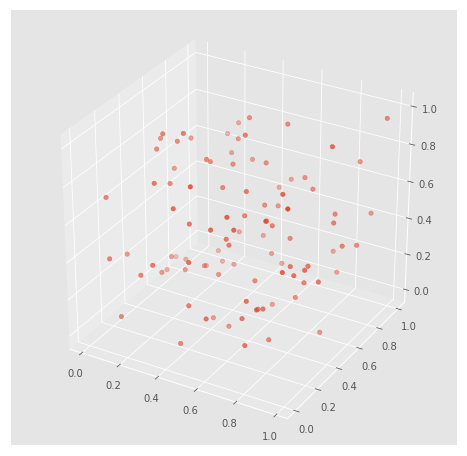

In [22]:
plot_3d(x0_i)

In [23]:
scale_factor

array([-9.71673123, 19.46781284])

import timeit

start = timeit.default_timer()

[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

stop = timeit.default_timer()

print(stop - start) 

In [24]:
# analytical answer
pair_potential = np.zeros(shape=(num_particles,num_particles)) 
for i in range(0, num_particles):
    for j in range(i+1, num_particles):
        pair_potential[i][j] = 1 / (op.distance_cal(x0_i[i], x0_i[j]) * scale_factor[1])
        
pair_potential

array([[0.        , 0.06224657, 0.14072209, ..., 0.08136087, 0.07090479,
        0.19840725],
       [0.        , 0.        , 0.05598314, ..., 0.05925062, 0.05140039,
        0.05483311],
       [0.        , 0.        , 0.        , ..., 0.12448559, 0.06876104,
        0.38586103],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.09741436,
        0.10304973],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06972475],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [25]:
J_analytic = np.zeros(num_particles)
for i in range(0, num_particles):
    for j in range(0, num_particles):
        if j<i:
            J_analytic[i] += pair_potential[j][i]
        if j>i:
            J_analytic[i] += pair_potential[i][j]

J_analytic

array([11.72835117,  7.80962614, 10.14222288, 10.29805727,  9.23516165,
        6.65329414,  9.0570879 ,  8.61452693, 10.95772493,  9.20379202,
        9.62247537, 11.65505052,  9.25138737, 11.4881902 ,  9.08313689,
        7.36296453, 10.61402663, 11.75976541, 11.56400629,  8.7821034 ,
        8.99320151, 11.89713972, 11.21865011, 11.00612421, 10.26733736,
       10.72242169, 12.05609309, 12.17597527, 11.81858482, 12.09333596,
       10.06404154,  9.5164303 ,  7.62072829, 10.51277098,  9.47109954,
       10.45105888, 11.8945991 , 11.99208561,  7.83770729,  9.43394939,
       10.27871503, 10.11620132,  9.30592837, 10.14853133, 10.98875941,
       10.45638641,  9.72904855, 11.32562003,  8.59308141, 10.33556186,
        7.94642929,  9.01585139,  9.51420109, 11.2546339 , 11.60038297,
        9.24193052,  9.59444803,  8.24748512, 12.28015266,  9.22202685,
        9.12703971,  9.13225223,  7.77707065, 10.50181528,  9.61844972,
        9.45565219,  8.1121277 , 11.70054685,  9.14066413,  9.61

In [26]:
total_energy = 0.5 * sum(J_analytic)
total_energy

495.0231095866051

In [29]:
from fast_multipole_method import fmm
from fast_multipole_method import fmm_q_source as fq

In [30]:
# build list of q_source
q_source = np.ndarray(shape=(len(x0_i)), dtype=fq) 
for i in range(0, len(x0_i)):
    q_source[i] = fq(x0_i[i], q[i])

In [31]:
btm_level = 3
p = 10
ws_index = 3
[J_far_field, J_near_field] = fmm(q_source, btm_level, p, ws_index)

constructions of level  3
constructions of level  2
constructions finished, procede to evaluation of interactions
interactions at level  3
Start to evaluating J matrix based on near and far field
J matrix ecaluation finished!


In [32]:
J_far_field /=  scale_factor[1]
J_far_field

array([5.71088583, 4.88144063, 4.83607365, 4.11713474, 5.29264572,
       5.10497515, 4.08586501, 4.68443578, 3.80805524, 4.29020936,
       4.30657761, 3.76454887, 4.4199185 , 3.10141689, 4.77752084,
       5.04072684, 4.66072393, 9.39339963, 4.13927431, 5.63883566,
       5.22799587, 3.49442534, 4.54352406, 3.69561058, 3.80061484,
       3.20197039, 2.89987945, 2.35099308, 3.13760062, 2.51593642,
       5.14114422, 3.63565837, 5.08854334, 4.0249807 , 4.57949022,
       3.90354284, 3.5825538 , 2.79150161, 4.67778109, 4.53048713,
       4.33226659, 3.94791289, 4.69401598, 5.08055078, 4.39101504,
       4.62820343, 4.30788489, 4.52192406, 5.62207718, 4.88567541,
       5.13544338, 4.15701303, 3.8903844 , 4.42459723, 3.95930065,
       4.13649344, 3.77610307, 9.83309521, 2.48560559, 4.59598512,
       5.33308456, 4.59592453, 5.19499605, 4.11929153, 4.00322853,
       5.56145573, 4.71972034, 4.05265193, 5.29815504, 4.56284702,
       3.87174165, 7.81579612, 4.64106796, 5.099277  , 4.16675

In [33]:
J_near_field /=  scale_factor[1]
J_near_field

array([ 8.91734479,  2.92818552,  5.30614923,  6.18092254,  3.94251593,
        1.54831899,  4.97122289,  3.93009115,  7.14966969,  4.91358267,
        5.31589775,  7.89050165,  4.83146887,  8.38677331,  4.30561605,
        2.32223769,  5.9533027 ,  6.90988984,  7.42473198,  3.14326774,
        3.76520563,  8.40271438,  6.67512606,  7.31051363,  6.46672252,
        7.52045129,  9.15621364,  9.82498218,  8.6809842 ,  9.57739954,
        4.92289731,  5.88077194,  2.53218495,  6.48779029,  4.89160932,
        6.54751603,  8.3120453 ,  9.200584  ,  3.1599262 ,  4.90346226,
        5.94644844,  6.16828843,  4.61191239,  5.06798056,  6.59774437,
        5.82818298,  5.42116366,  6.80369597,  2.97100423,  5.44988645,
        2.8109859 ,  4.85883836,  5.62381669,  6.83003667,  7.64108232,
        5.10543708,  5.81834497,  3.30249655,  9.79454707,  4.62604174,
        3.79395515,  4.53632771,  2.5820746 ,  6.38252375,  5.61522119,
        3.89419645,  3.39240736,  7.64789492,  3.84250909,  5.05

In [34]:
J_total = J_far_field + J_near_field
J_total

array([14.62823062,  7.80962614, 10.14222288, 10.29805727,  9.23516165,
        6.65329414,  9.0570879 ,  8.61452693, 10.95772493,  9.20379202,
        9.62247537, 11.65505052,  9.25138737, 11.4881902 ,  9.08313689,
        7.36296453, 10.61402663, 16.30328947, 11.56400629,  8.7821034 ,
        8.99320151, 11.89713972, 11.21865011, 11.00612421, 10.26733736,
       10.72242169, 12.05609309, 12.17597527, 11.81858482, 12.09333596,
       10.06404154,  9.5164303 ,  7.62072829, 10.51277098,  9.47109954,
       10.45105888, 11.8945991 , 11.99208561,  7.83770729,  9.43394939,
       10.27871503, 10.11620132,  9.30592837, 10.14853133, 10.98875941,
       10.45638641,  9.72904855, 11.32562003,  8.59308141, 10.33556186,
        7.94642929,  9.01585139,  9.51420109, 11.2546339 , 11.60038297,
        9.24193052,  9.59444803, 13.13559176, 12.28015266,  9.22202685,
        9.12703971,  9.13225223,  7.77707065, 10.50181528,  9.61844972,
        9.45565219,  8.1121277 , 11.70054685,  9.14066413,  9.61

In [35]:
total_energy = 0.5 * sum(J_total)
total_energy

503.1196110815346

In [36]:
J_error = np.abs(J_total-J_analytic) / J_analytic
J_error

array([2.47253805e-01, 9.75109644e-13, 5.43298937e-13, 1.33269146e-12,
       6.21723629e-12, 1.42411972e-12, 1.76516025e-14, 1.41044086e-12,
       6.79240919e-12, 1.42937810e-12, 3.43734466e-13, 7.57268841e-12,
       1.13516181e-12, 4.25047569e-12, 5.02273314e-12, 5.58036395e-12,
       2.22755325e-13, 3.86361794e-01, 1.14516889e-12, 3.97541634e-12,
       1.06523716e-12, 1.67271513e-12, 1.14479548e-12, 5.11176984e-12,
       2.36055482e-12, 2.68613291e-11, 1.33048925e-13, 4.61859552e-12,
       2.78058685e-14, 1.04025549e-12, 1.80098965e-11, 5.21347238e-13,
       1.83247962e-12, 1.59970222e-11, 2.15369984e-12, 6.40698439e-12,
       1.15763529e-11, 1.82892940e-12, 6.55597156e-12, 1.69238721e-12,
       9.21349721e-12, 6.67788713e-13, 9.80344259e-12, 3.05945168e-12,
       1.33557025e-12, 9.88053483e-12, 2.24868966e-12, 6.64077979e-13,
       2.08786618e-13, 8.97496967e-12, 1.92625723e-12, 1.50133787e-13,
       6.32484680e-12, 1.76773379e-12, 1.45166439e-13, 5.50286504e-13,
      